In [1]:
from persor import BVHparser
import numpy as np


In [2]:
class console:
    @staticmethod
    def log(*args):
        print(*args)

In [3]:
def get_joint_coords(skeleton, joint, coords):
    offset = skeleton[joint]["offset"]
    parent_joint = skeleton[joint]["joint"]
    child_joints = skeleton[joint]["children"]

    if parent_joint == None:
        return

    parent_coord = coords[parent_joint]["coord"]

    current_coord = [
        parent_coord[0] + offset[0],
        parent_coord[1] + offset[1],
        parent_coord[2] + offset[2],
    ]
    coords[joint] = {"coord": current_coord, "parent": parent_joint}

    for child in child_joints:
        get_joint_coords(skeleton, child, coords)


def skelton2coords(skeleton):
    coords = {"root": {"coord": skeleton["root"]["offset"], "parent": None}}
    skeleton["root"]

    child_joints = skeleton["root"]["children"]
    for child in child_joints:
        get_joint_coords(skeleton, child, coords)

    get_joint_coords(skeleton, "root", coords)

    return coords


def rotate(origin, end, roll, pitch, yaw):
    vec = np.array(end) - np.array(origin)

    r_x = np.array(
        [[1, 0, 0], [0, np.cos(roll), -np.sin(roll)], [0, np.sin(roll), np.cos(roll)]]
    )
    r_y = np.array(
        [
            [np.cos(pitch), 0, np.sin(pitch)],
            [0, 1, 0],
            [-np.sin(pitch), 0, np.cos(pitch)],
        ]
    )
    r_z = np.array(
        [[np.cos(yaw), -np.sin(yaw), 0], [np.sin(yaw), np.cos(yaw), 0], [0, 0, 1]]
    )

    vec = np.dot(r_x, vec)
    vec = np.dot(r_y, vec)
    vec = np.dot(r_z, vec)

    return vec + origin


def rotated_coord(coord, frame):
    for joint, data in coord.items():
        if joint == "root":
            continue

        x_rotate = frame[f"{joint}_Xrotation"]
        y_rotate = frame[f"{joint}_Yrotation"]
        z_rotate = frame[f"{joint}_Zrotation"]

        parent = coord[joint]["parent"]
        coord[joint]["coord"] = rotate(
            coord[parent]["coord"],
            coord[joint]["coord"],
            z_rotate,
            x_rotate,
            y_rotate,
        )

In [4]:
bvhp = BVHparser("./data/jump.bvh")


In [5]:
skeleton = bvhp.get_skeleton()
motion_df = bvhp.get_motion_df()
motion_frame = motion_df.iloc[100,:]

coords = skelton2coords(skeleton)

rotated_coord(coords, motion_frame)


In [6]:
import matplotlib.pyplot as plt
import japanize_matplotlib


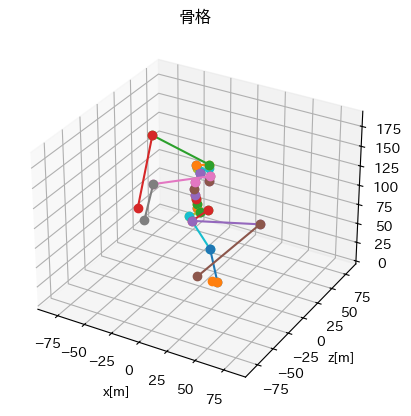

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
for joint, coord in coords.items():
    if coord["parent"] == None:
        continue
    parent_coord = coords[coord["parent"]]["coord"]
    ax.plot(
        [parent_coord[0], coord["coord"][0]],
        [parent_coord[2], coord["coord"][2]],
        [parent_coord[1], coord["coord"][1]],
        marker="o",
    )

plt.title('骨格')
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.ylabel('z[m]')
ax.set_xlim(-90, 90)
ax.set_ylim(-90, 90)
ax.set_zlim(0, 190)

plt.show()